# Data import & first check

In [ ]:
import pandas as pd
import spacy
import re
import numpy as np
import tensorflow as tf
!pip install tensorflow_addons -q
import tensorflow_addons as tfa
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
import plotly.express as px
pd.set_option('display.max_rows', 100)
from sklearn.model_selection import train_test_split

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Deep learning/Project_NLP_Twitter/nlp_getting_started/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Deep learning/Project_NLP_Twitter/nlp_getting_started/test.csv")

In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df = pd.concat([df_train,df_test])
df.shape

(10876, 5)

In [ ]:
#Check of target distribution
fig = px.histogram(df_train, x="target")
fig.update_layout(bargap=0.2)
fig.show()

# Data augmentation

In [ ]:
#Addition of new features from those that already exist
#Count of words composing the tweet
df["nb_words"] = df['text'].str.split().str.len()

In [ ]:
#Count of characters composing the tweet
df["nb_characters"] = df['text'].apply(lambda x: len(''.join(x.split())))

In [ ]:
#Count of hashtags in each tweet (#)
df["nb_hashtag"] = df['text'].apply(lambda x: len([t for t in x.split() if t.startswith('#')]))

In [ ]:
#Count of mentions in each tweet (@)
df["nb_mention"] = df['text'].apply(lambda x: len([t for t in x.split() if t.startswith('@')]))

In [ ]:
#Count of hypertext links in each tweet (http...)
df["nb_link"] = df['text'].apply(lambda x: len([t for t in x.split() if t.startswith('http')]))

In [ ]:
#Average number of word in each tweet
df["avg_word_size"] = df["nb_characters"]/df["nb_words"]

In [ ]:
#Count of UPPERCASE words in each tweet
df["nb_uppercase_word"] = df['text'].apply(lambda x: len([t for t in x.split() if t.isupper() and len(t) > 1]))

In [ ]:
#Is there an keyword or not ?
df['keyword'] = df['keyword'].fillna(0)
df['keyword'][df['keyword'] != 0] = 1
df["keyword"] = df["keyword"].astype(np.int64)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#Let's summurize
df.head(300)

,id,keyword,location,text,target,nb_words,nb_characters,nb_hashtag,nb_mention,nb_link,avg_word_size,nb_uppercase_word
0,1,0,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,13,57,1,0,0,4.384615,1
1,4,0,NaN,Forest fire near La Ronge Sask. Canada,1.0,7,32,0,0,0,4.571429,0
2,5,0,NaN,All residents asked to 'shelter in place' are ...,1.0,22,112,0,0,0,5.090909,0
3,6,0,NaN,"13,000 people receive #wildfires evacuation or...",1.0,8,57,1,0,0,7.125000,0
4,7,0,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,16,72,2,0,0,4.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
295,435,1,NaN,Minecraft- NIGHT LUCKY BLOCK MOD (BOB APOCALYP...,0.0,17,118,0,1,1,6.941176,8
296,436,1,NaN,Shot Through The Heart XV: You are going to to...,0.0,21,120,0,0,2,5.714286,1
297,437,1,NaN,RT: Geek_Apocalypse: 4pm GMT :Hesse plays dark...,0.0,14,101,1,0,2,7.214286,2
298,438,1,Las Vegas,I know where to go when the zombies take over!...,0.0,11,60,0,0,1,5.454545,0


In [ ]:
#Check of missing values share
print(100*df.isna().sum()/df.shape[0])

id                    0.000000
keyword               0.000000
location             33.449798
text                  0.000000
target               30.001839
nb_words              0.000000
nb_characters         0.000000
nb_hashtag            0.000000
nb_mention            0.000000
nb_link               0.000000
avg_word_size         0.000000
nb_uppercase_word     0.000000
dtype: float64


# Tweets cleaning, preprocessing & tokenization

In [ ]:
#Import of the spacy langage package
!python -m spacy download en_core_web_md -q
import en_core_web_md


     |████████████████████████████████| 96.4 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
nlp = en_core_web_md.load()

In [ ]:
#Import of the stop words
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
#Tweets cleaning
def text_cleaner(text):
  text = "".join([c for c in text if c.isalnum() or c == " "])
  text = re.sub(" +", " ", text).lower().strip()
  text = " ".join([token.lemma_ for token in nlp(text) if token.text not in STOP_WORDS and token.lemma_ not in STOP_WORDS])
  text = " ".join(c for c in text.split() if len(c) > 1)
  return text

In [ ]:
#Tweets cleaning : processing
df["cleaned_text"] = df["text"].apply(lambda x: text_cleaner(x))

In [ ]:
#Let's summurize
df.head(10)

,id,keyword,location,text,target,nb_words,nb_characters,nb_hashtag,nb_mention,nb_link,avg_word_size,nb_uppercase_word,cleaned_text
0,1,0,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,13,57,1,0,0,4.384615,1,deed reason earthquake allah forgive
1,4,0,NaN,Forest fire near La Ronge Sask. Canada,1.0,7,32,0,0,0,4.571429,0,forest fire near la ronge sask canada
2,5,0,NaN,All residents asked to 'shelter in place' are ...,1.0,22,112,0,0,0,5.090909,0,resident ask shelter place notify officer evac...
3,6,0,NaN,"13,000 people receive #wildfires evacuation or...",1.0,8,57,1,0,0,7.125000,0,13000 people receive wildfire evacuation order...
4,7,0,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,16,72,2,0,0,4.500000,0,send photo ruby alaska smoke wildfire pour school
5,8,0,NaN,#RockyFire Update => California Hwy. 20 closed...,1.0,18,93,3,0,0,5.166667,0,rockyfire update california hwy 20 close direc...
6,10,0,NaN,#flood #disaster Heavy rain causes flash flood...,1.0,14,82,2,0,0,5.857143,0,flood disaster heavy rain cause flash flooding...
7,13,0,NaN,I'm on top of the hill and I can see a fire in...,1.0,15,45,0,0,0,3.000000,0,hill fire wood
8,14,0,NaN,There's an emergency evacuation happening now ...,1.0,12,68,0,0,0,5.666667,0,emergency evacuation happen building street
9,15,0,NaN,I'm afraid that the tornado is coming to our a...,1.0,10,43,0,0,0,4.300000,0,afraid tornado come area


In [ ]:
# Tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000) # instanciate the tokenizer
tokenizer.fit_on_texts(df["cleaned_text"])
df["text_encoded"] = tokenizer.texts_to_sequences(df["cleaned_text"])
df["len_text"] = df["text_encoded"].apply(lambda x: len(x))
#df = df[df["len_text"]!=0]

In [ ]:
len(tokenizer.word_index)

26828

In [ ]:
#Let's summurize
df.head()

,id,keyword,location,text,target,nb_words,nb_characters,nb_hashtag,nb_mention,nb_link,avg_word_size,nb_uppercase_word,cleaned_text,text_encoded,len_text
0,1,0,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,13,57,1,0,0,4.384615,1,deed reason earthquake allah forgive,"[4675, 389, 162, 1640, 1983]",5
1,4,0,NaN,Forest fire near La Ronge Sask. Canada,1.0,7,32,0,0,0,4.571429,0,forest fire near la ronge sask canada,"[87, 2, 131, 607, 1093]",5
2,5,0,NaN,All residents asked to 'shelter in place' are ...,1.0,22,112,0,0,0,5.090909,0,resident ask shelter place notify officer evac...,"[1149, 405, 1641, 344, 279, 185, 1641, 344, 24...",10
3,6,0,NaN,"13,000 people receive #wildfires evacuation or...",1.0,8,57,1,0,0,7.125000,0,13000 people receive wildfire evacuation order...,"[2554, 5, 1500, 69, 185, 249, 41]",7
4,7,0,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,16,72,2,0,0,4.500000,0,send photo ruby alaska smoke wildfire pour school,"[163, 123, 4676, 1984, 164, 69, 2225, 124]",8


# Selection of inputs & target

In [ ]:
#Selection of rows from the original df_train
df_with_target = df[~df['target'].isna()]

In [ ]:
df_with_target.shape

(7613, 15)

In [ ]:
#Addition of padding
text_with_padding = tf.keras.preprocessing.sequence.pad_sequences(df_with_target["text_encoded"], padding="post")

In [ ]:
#Selection of the features to keep in addition of the NLP scope
vector = df_with_target[["keyword", "nb_words",	"nb_characters",	"nb_hashtag",	"nb_mention",	"nb_link",	"avg_word_size",	"nb_uppercase_word"]]

In [ ]:
#Selection of the target
target = df_with_target["target"]

In [ ]:
#Split in Train/Validation
text_train, text_val, vector_train, vector_val, target_train, target_val = train_test_split(text_with_padding, vector.values, target.values, test_size=0.05 )

# Design of the neural network model

In [ ]:
from tensorflow.keras.regularizers import L2
l2 = L2(l2=0.02)


#Inputs
input_text = tf.keras.Input(shape=text_with_padding.shape[1], name="input_layer_text")
input_vector = tf.keras.Input(shape=vector.shape[1], name="input_layer_features")

embed = tf.keras.layers.Embedding(input_dim=len(tokenizer.index_word), output_dim=16, mask_zero=True, name="text_embedding")
lstm = tf.keras.layers.LSTM(32, name="text_LMST")
dropout = tf.keras.layers.Dropout(rate=0.2, name="dropout")

dense1 = tf.keras.layers.Dense(64, activation="relu", name="features_dense_1",kernel_regularizer=l2)
dense2 = tf.keras.layers.Dense(32, activation="relu", name="features_dense_2",kernel_regularizer=l2)

pred = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")

embed_out = embed(input_text)
dropout_out = dropout(embed_out)
lstm_out = lstm(dropout_out)

dense1_out = dense1(input_vector)
dense2_out = dense2(dense1_out)

#Concatenation of the 2 flows
concat = tf.keras.layers.concatenate([lstm_out, dense2_out], name="concatenation")

pred_out = pred(concat)

model = tf.keras.Model(inputs = [input_text, input_vector], outputs = pred_out)

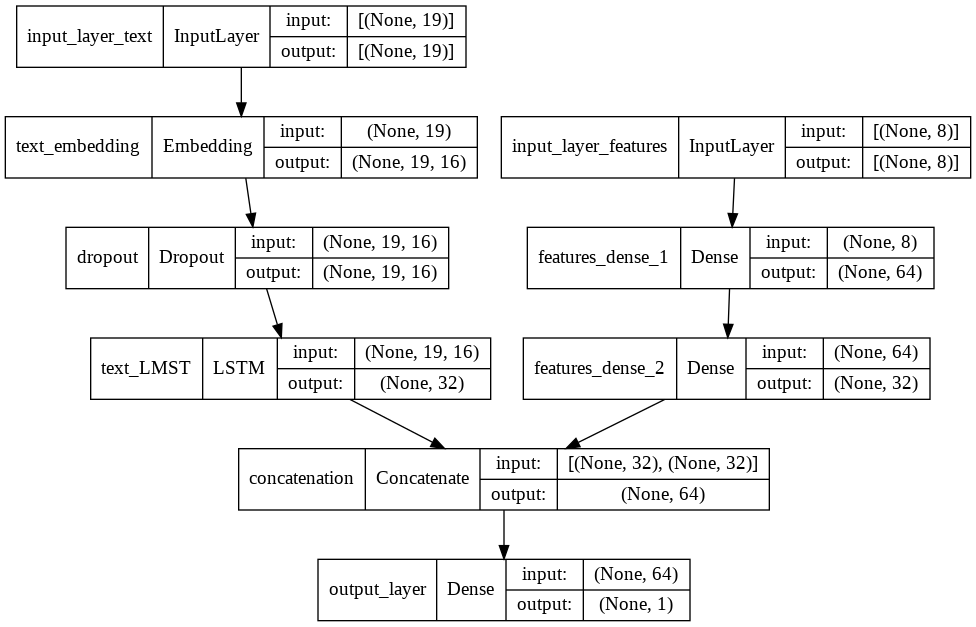

In [ ]:
#Visualization of the model
tf.keras.utils.plot_model(model, show_shapes=True)

# Training & performance

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/Deep learning/Project_NLP_Twitter/nlp_getting_started/model.h5',
                                                monitor='val_binary_accuracy',
                                                save_best_only=True,
                                                mode='max')

#Model training
history = model.fit(x= [text_train, vector_train], y=target_train, validation_data=([text_val, vector_val], target_val), epochs=20, batch_size=100,callbacks=[checkpoint])

Epoch 1/20
73/73 [==============================] - 8s 48ms/step - loss: 1.5396 - binary_accuracy: 0.6150 - val_loss: 1.1724 - val_binary_accuracy: 0.7402
Epoch 2/20
73/73 [==============================] - 2s 27ms/step - loss: 0.9702 - binary_accuracy: 0.8100 - val_loss: 0.8409 - val_binary_accuracy: 0.8084
Epoch 3/20
73/73 [==============================] - 2s 27ms/step - loss: 0.7164 - binary_accuracy: 0.8532 - val_loss: 0.7300 - val_binary_accuracy: 0.8110
Epoch 4/20
73/73 [==============================] - 2s 27ms/step - loss: 0.5935 - binary_accuracy: 0.8736 - val_loss: 0.6866 - val_binary_accuracy: 0.8189
Epoch 5/20
73/73 [==============================] - 2s 27ms/step - loss: 0.5248 - binary_accuracy: 0.8899 - val_loss: 0.6871 - val_binary_accuracy: 0.8084
Epoch 6/20
73/73 [==============================] - 2s 26ms/step - loss: 0.4683 - binary_accuracy: 0.9056 - val_loss: 0.7026 - val_binary_accuracy: 0.8110
Epoch 7/20
73/73 [==============================] - 2s 26ms/step - los

In [ ]:
#Lost function plot
from plotly import graph_objects as go
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["loss"],
                          name="Training data loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history.history["val_loss"],
                          name="Validation data loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training data VS validation data loss across epochs',
    xaxis_title='epochs',
    yaxis_title='BinaryCrossentropy loss'
)
fig.show()

In [ ]:
#Accuracy of the model (Binary accuracy)
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["binary_accuracy"],
                          name="Training data accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[4]
                          )),
                      go.Scatter(
                          y=history.history["val_binary_accuracy"],
                          name="Validation data accruracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[5]
                          ))
])
fig.update_layout(
    title='Training data VS validation data accuracy score across epochs',
    xaxis_title='epochs',
    yaxis_title='BinaryAccuracy score'    
)
fig.show()

# Prediction for Kaggle submission

In [ ]:
sample = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Deep learning/Project_NLP_Twitter/nlp_getting_started/sample_submission.csv")

In [ ]:
#Selection of rows from the original df_test
df_test = df[df['target'].isna()]

In [ ]:
#Addition of padding
text_with_padding_test = tf.keras.preprocessing.sequence.pad_sequences(df_test["text_encoded"], padding="post")

In [ ]:
#Selection of the features to keep in addition of the NLP scope
vector_test = df_test[["keyword", "nb_words",	"nb_characters",	"nb_hashtag",	"nb_mention",	"nb_link",	"avg_word_size",	"nb_uppercase_word"]]

In [ ]:
#Check of the model input shape (train vs test)
text_with_padding.shape

(7613, 19)

In [ ]:
text_with_padding_test.shape

(3263, 20)

In [ ]:
#There is one more dimension in the test set so we have to remove the last dimension
text_with_padding_test = text_with_padding_test[:,:19]

In [ ]:
text_with_padding_test.shape


(3263, 19)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Deep learning/Project_NLP_Twitter/nlp_getting_started/model.h5')
y_pre = model.predict([text_with_padding_test, vector_test])

In [ ]:
sample["target"] = y_pre.round().astype(int)

In [ ]:
sample.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
sample.to_csv('/content/drive/MyDrive/Colab Notebooks/Deep learning/Project_NLP_Twitter/nlp_getting_started/submission.csv', index=False)